## Abstract

### Can you identify Sarcastic sentences?
### Can you distinguish between Fake news and Legitimate news?

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

### Dataset

Each record consists of three attributes:

is_sarcastic: 1 if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data

### Deep Learning Framework
I will be using Tensorflow to implement the Deep Learning Models for this Project.

### Import the libraries

In [6]:
import json
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau 


import warnings
warnings.filterwarnings("ignore")


### Loading the Dataset

In [7]:
df_News = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json', lines=True)
df_2 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
df_News.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


### Joining the two Datasets

In [8]:
df_News = pd.concat([df_News, df_2], ignore_index=True)
df_News.shape

(55328, 3)

### Exploratory Data Analysis

In [9]:
df_News.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  55328 non-null  int64 
 1   headline      55328 non-null  object
 2   article_link  55328 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [10]:
# looking at some sarcastic news
df_News[df_News.is_sarcastic == 1].head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...


In [11]:
# looking at some legitimate news
df_News[df_News.is_sarcastic == 0].head(5)

,is_sarcastic,headline,article_link
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


### Target Column Distribution

In [12]:
df_News.is_sarcastic.value_counts()

0    29970
1    25358
Name: is_sarcastic, dtype: int64

The dataset appears to be balanced for Sarcastic and legitimate news

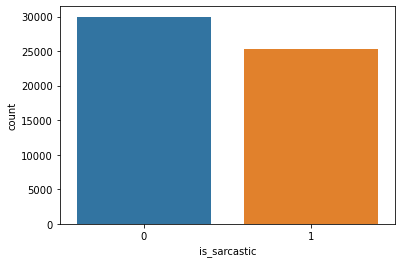

In [13]:
sns.countplot(df_News.is_sarcastic)

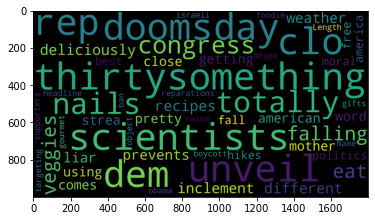

In [14]:
wordcloud = WordCloud(background_color='black',
                    stopwords = STOPWORDS,
                    max_words = 100,
                    random_state = 101, 
                    width=1800, 
                    height=1000)
wordcloud.generate(str(df_News['headline']))
plt.imshow(wordcloud)

### News Headline length Distribution

In [15]:
df_News['headline_len'] = df_News.headline.apply(lambda x: len(x.split()))

In [16]:
sarcastic = df_News[df_News.is_sarcastic == 1]
legit = df_News[df_News.is_sarcastic == 0]

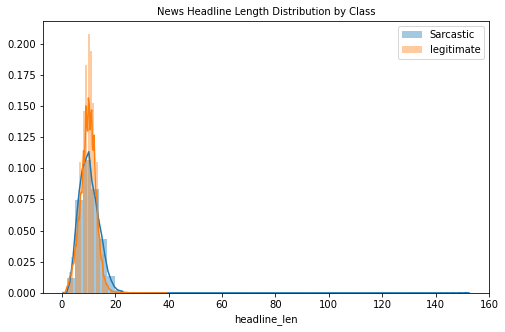

In [17]:
plt.figure(figsize=(8,5))
sns.distplot(sarcastic.headline_len, hist= True, label= 'Sarcastic')
sns.distplot(legit.headline_len, hist= True, label= 'legitimate')
plt.legend()
plt.title('News Headline Length Distribution by Class', fontsize = 10)
plt.show()

### Data Cleaning & Pre-processing

I will be doing just some basic Pre-processing, as these are News Headlines which are written by Professionals in a formal way, so to not remove anything which can help with context, I will only remove punctuations and apply lemmatization

In [18]:
df_News = df_News.drop(columns=['article_link'])

In [19]:
lem = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
punctuations = string.punctuation

In [20]:
def clean_text(news):
    """
    This function receives headlines sentence and returns clean sentence
    """
    news = news.lower()
    news = re.sub("\\n", "", news)
    #news = re.sub("\W+", " ", news)
    
    #Split the sentences into words
    words = list(news.split())
    
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if w not in punctuations]
    #words = [w for w in words if w not in stop_words]
    #words = [''.join(x for x in w if x.isalpha()) for w in words]

    clean_sen = " ".join(words)
    
    return clean_sen

In [21]:
df_News['news_headline'] = df_News.headline.apply(lambda news: clean_text(news)) 
df_News.head()

,is_sarcastic,headline,headline_len,news_headline
0,1,thirtysomething scientists unveil doomsday clo...,8,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,13,dem rep. totally nail why congress be fall sho...
2,0,eat your veggies: 9 deliciously different recipes,7,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,8,inclement weather prevent liar from get to work
4,1,mother comes pretty close to using word 'strea...,9,mother come pretty close to use word 'streamin...


In [22]:
df_News.groupby(['is_sarcastic']).headline_len.mean()

is_sarcastic
0     9.815616
1    10.111917
Name: headline_len, dtype: float64

In [23]:
df_News.groupby(['is_sarcastic']).headline_len.max()

is_sarcastic
0     38
1    151
Name: headline_len, dtype: int64

On an Average most of the headlines have same length, in some cases, Sarcastic headlines are longer. 

### Stratified Split 

I am using Stratified split to sample approx equal number of instances for training for both the categories of our Target.

In [24]:
headlines = df_News['news_headline']
labels = df_News['is_sarcastic'] 

In [25]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(headlines, labels, test_size=0.2, stratify=labels, random_state=42)

In [26]:
train_labels.value_counts()

0    23976
1    20286
Name: is_sarcastic, dtype: int64

### Converting News Headlines into Sequences of tokens

In [27]:
#Defining Hyperparameters to be used

max_words = 30000     # how many unique words to use (i.e num rows in embedding vector)
max_len = 70       # max number of words in a headline to use
oov_token = '00_V'    # for the words which are not in training samples
padding_type = 'post'   # padding type
trunc_type = 'post'    # truncation for headlines longer than max length
embed_size = 100    # how big is each word vector

In [28]:
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

In [29]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [30]:
train_sequences

array([[  380,   110,   376, ...,     0,     0,     0],
       [   73,  1091,   302, ...,     0,     0,     0],
       [  416,  1197,     7, ...,     0,     0,     0],
       ...,
       [   12,   112,    53, ...,     0,     0,     0],
       [ 9417,     2,   587, ...,     0,     0,     0],
       [14569, 14570,   121, ...,     0,     0,     0]], dtype=int32)

### Predictive Modeling
Our aim is to build a binary Classification model which given a sequence of text, can classify it as Sarcastic or not, or Fake news or real news.

### A. I will try below different models and see which works best.
1. Neural Network with Embedding
2. RNN(Recurrent Neural Network)
3. LSTM(Long-short term Memory) with GlobalAveragePooling
4. LSTM with GlobalMaxPooling
5. Stacked LSTM
6. Bidirectional LSTM
7. GRU(Gated Recurrent Unit)
8. Stacked Bidirectional LSTM
9. Best Model from above with pre-trained Embeddings

### 1. Neural Network with Embedding

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 100)           3000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,001,633
Trainable params: 3,001,633
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(train_sequences, train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_sequences, test_labels), 
                    callbacks=[rlrp] ,verbose=1)

Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 45s 1ms/sample - loss: 0.3928 - accuracy: 0.8317 - val_loss: 0.2226 - val_accuracy: 0.9149
Epoch 2/5
44262/44262 [==============================] - 43s 964us/sample - loss: 0.1180 - accuracy: 0.9612 - val_loss: 0.1292 - val_accuracy: 0.9558
Epoch 3/5
44262/44262 [==============================] - 42s 941us/sample - loss: 0.0314 - accuracy: 0.9921 - val_loss: 0.1143 - val_accuracy: 0.9660
Epoch 4/5
44262/44262 [==============================] - 43s 978us/sample - loss: 0.0074 - accuracy: 0.9989 - val_loss: 0.1339 - val_accuracy: 0.9667
Epoch 5/5
44262/44262 [==============================] - 44s 984us/sample - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.1569 - val_accuracy: 0.9669


11066/11066 [==============================] - 1s 76us/sample - loss: 0.1569 - accuracy: 0.9669
Test Loss:  0.15688867683240634
Test Accuracy 0.96692574
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


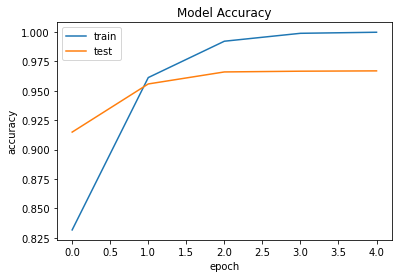

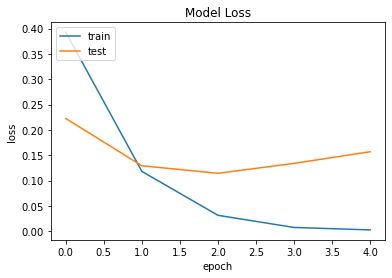

In [33]:
score = model.evaluate(test_sequences, test_labels)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2. RNN (Recurrent Neural Network)

In [34]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 100)           3000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 100)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 70, 32)            4256      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [35]:
history_rnn = model_rnn.fit(train_sequences, train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_sequences, test_labels), 
                    callbacks=[rlrp] ,verbose=1)

Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 115s 3ms/sample - loss: 0.5636 - accuracy: 0.6950 - val_loss: 0.3578 - val_accuracy: 0.8478
Epoch 2/5
44262/44262 [==============================] - 115s 3ms/sample - loss: 0.2988 - accuracy: 0.8859 - val_loss: 0.2351 - val_accuracy: 0.9095
Epoch 3/5
44262/44262 [==============================] - 113s 3ms/sample - loss: 0.1690 - accuracy: 0.9406 - val_loss: 0.1902 - val_accuracy: 0.9276
Epoch 4/5
44262/44262 [==============================] - 112s 3ms/sample - loss: 0.1042 - accuracy: 0.9656 - val_loss: 0.1636 - val_accuracy: 0.9472
Epoch 5/5
44262/44262 [==============================] - 112s 3ms/sample - loss: 0.0680 - accuracy: 0.9777 - val_loss: 0.1563 - val_accuracy: 0.9533


11066/11066 [==============================] - 3s 290us/sample - loss: 0.1563 - accuracy: 0.9533
Test Loss:  0.15628284895811118
Test Accuracy 0.9532803
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


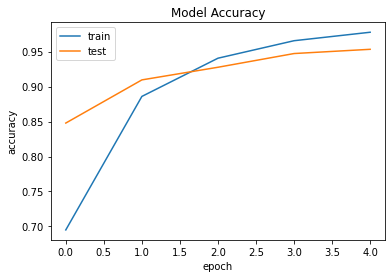

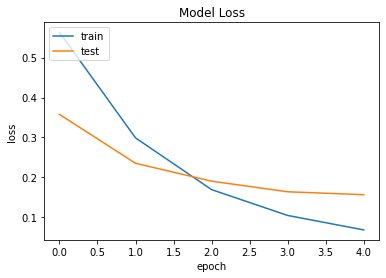

In [36]:
score = model_rnn.evaluate(test_sequences, test_labels)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_rnn.history.keys())
# summarize history for accuracy
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 3. LSTM (Long Short Term Memory) with GlobalMaxPooling & SpatialDropout

In [37]:
from tensorflow.keras.callbacks import ReduceLROnPlateau 

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 100)           3000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 70, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 70, 32)            17024     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [38]:
history_lstm = model_lstm.fit(train_sequences, train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_sequences, test_labels), 
                    callbacks=[rlrp] ,verbose=1)

Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 221s 5ms/sample - loss: 0.3532 - accuracy: 0.8437 - val_loss: 0.2286 - val_accuracy: 0.9095
Epoch 2/5
44262/44262 [==============================] - 218s 5ms/sample - loss: 0.1527 - accuracy: 0.9457 - val_loss: 0.1676 - val_accuracy: 0.9376
Epoch 3/5
44262/44262 [==============================] - 213s 5ms/sample - loss: 0.0805 - accuracy: 0.9724 - val_loss: 0.1486 - val_accuracy: 0.9534
Epoch 4/5
44262/44262 [==============================] - 214s 5ms/sample - loss: 0.0462 - accuracy: 0.9845 - val_loss: 0.1392 - val_accuracy: 0.9602
Epoch 5/5
44262/44262 [==============================] - 223s 5ms/sample - loss: 0.0287 - accuracy: 0.9904 - val_loss: 0.1609 - val_accuracy: 0.9646


11066/11066 [==============================] - 9s 782us/sample - loss: 0.1609 - accuracy: 0.9646
Test Loss:  0.1609382555255666
Test Accuracy 0.9645762
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


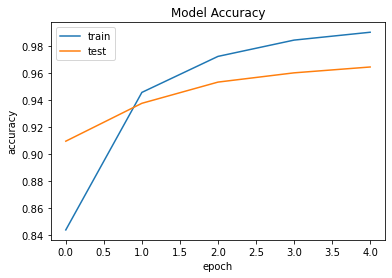

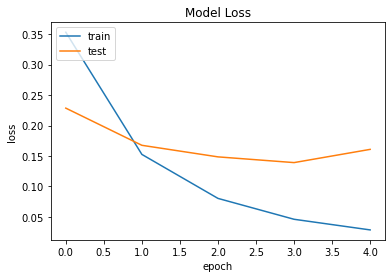

In [39]:
score = model_lstm.evaluate(test_sequences, test_labels)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4. LSTM with GlobalAveragePool

In [40]:
from tensorflow.keras.callbacks import ReduceLROnPlateau 

model_lstm_avg = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_lstm_avg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_avg.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 100)           3000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 70, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 32)            17024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [41]:
history_lstm_avg = model_lstm_avg.fit(train_sequences, train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_sequences, test_labels), 
                    callbacks=[rlrp] ,verbose=1)

Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 222s 5ms/sample - loss: 0.4457 - accuracy: 0.8138 - val_loss: 0.3478 - val_accuracy: 0.8792
Epoch 2/5
44262/44262 [==============================] - 214s 5ms/sample - loss: 0.2773 - accuracy: 0.9029 - val_loss: 0.2889 - val_accuracy: 0.9067
Epoch 3/5
44262/44262 [==============================] - 219s 5ms/sample - loss: 0.1916 - accuracy: 0.9339 - val_loss: 0.2514 - val_accuracy: 0.9186
Epoch 4/5
44262/44262 [==============================] - 216s 5ms/sample - loss: 0.1589 - accuracy: 0.9511 - val_loss: 0.2792 - val_accuracy: 0.9160
Epoch 5/5
44262/44262 [==============================] - 215s 5ms/sample - loss: 0.1452 - accuracy: 0.9506 - val_loss: 0.2286 - val_accuracy: 0.9273


11066/11066 [==============================] - 8s 690us/sample - loss: 0.2286 - accuracy: 0.9273
Test Loss:  0.22856178777398414
Test Accuracy 0.9272547
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


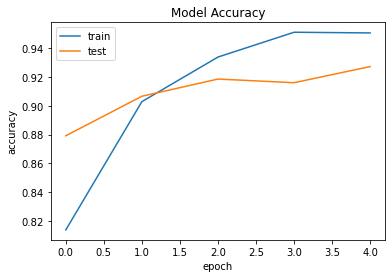

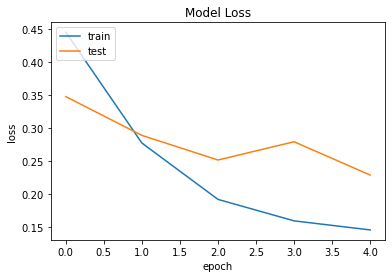

In [42]:
score = model_lstm_avg.evaluate(test_sequences, test_labels)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_lstm_avg.history.keys())
# summarize history for accuracy
plt.plot(history_lstm_avg.history['accuracy'])
plt.plot(history_lstm_avg.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm_avg.history['loss'])
plt.plot(history_lstm_avg.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 5. LSTM with only one FC Dense Layer

In [43]:
from tensorflow.keras.callbacks import ReduceLROnPlateau 

model_lstm1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_lstm1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 70, 100)           3000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 70, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70, 32)            17024     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 3,017,057
Trainable params: 3,017,057
Non-trainable params: 0
_________________________________________________________________


In [44]:
history_lstm1 = model_lstm1.fit(train_sequences, train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_sequences, test_labels), 
                    callbacks=[rlrp] ,verbose=1)

Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 216s 5ms/sample - loss: 0.3334 - accuracy: 0.8503 - val_loss: 0.2312 - val_accuracy: 0.9104
Epoch 2/5
44262/44262 [==============================] - 212s 5ms/sample - loss: 0.1394 - accuracy: 0.9486 - val_loss: 0.1642 - val_accuracy: 0.9406
Epoch 3/5
44262/44262 [==============================] - 212s 5ms/sample - loss: 0.0731 - accuracy: 0.9749 - val_loss: 0.1391 - val_accuracy: 0.9534
Epoch 4/5
44262/44262 [==============================] - 210s 5ms/sample - loss: 0.0415 - accuracy: 0.9859 - val_loss: 0.1374 - val_accuracy: 0.9589
Epoch 5/5
44262/44262 [==============================] - 212s 5ms/sample - loss: 0.0266 - accuracy: 0.9912 - val_loss: 0.1525 - val_accuracy: 0.9614


11066/11066 [==============================] - 7s 650us/sample - loss: 0.1525 - accuracy: 0.9614
Test Loss:  0.15254819644697531
Test Accuracy 0.9614133
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


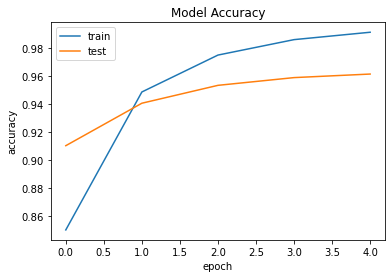

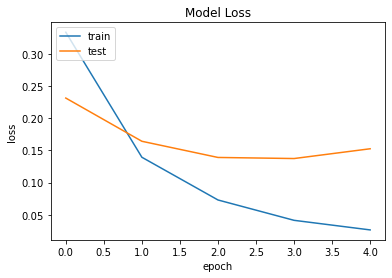

In [45]:
score = model_lstm1.evaluate(test_sequences, test_labels)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_lstm1.history.keys())
# summarize history for accuracy
plt.plot(history_lstm1.history['accuracy'])
plt.plot(history_lstm1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm1.history['loss'])
plt.plot(history_lstm1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Stacked LSTM

In [46]:
from tensorflow.keras.callbacks import ReduceLROnPlateau 

model_st_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_st_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_st_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 70, 100)           3000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 70, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70, 32)            17024     
_________________________________________________________________
lstm_4 (LSTM)                (None, 70, 32)            8320      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)               

In [47]:
history_st_lstm = model_st_lstm.fit(train_sequences, train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_sequences, test_labels), 
                    callbacks=[rlrp] ,verbose=1)

Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 383s 9ms/sample - loss: 0.3429 - accuracy: 0.8474 - val_loss: 0.2314 - val_accuracy: 0.9096
Epoch 2/5
44262/44262 [==============================] - 378s 9ms/sample - loss: 0.1489 - accuracy: 0.9484 - val_loss: 0.1768 - val_accuracy: 0.9363
Epoch 3/5
44262/44262 [==============================] - 375s 8ms/sample - loss: 0.0809 - accuracy: 0.9736 - val_loss: 0.1487 - val_accuracy: 0.9520
Epoch 4/5
44262/44262 [==============================] - 371s 8ms/sample - loss: 0.0489 - accuracy: 0.9839 - val_loss: 0.1637 - val_accuracy: 0.9564
Epoch 5/5
44262/44262 [==============================] - 371s 8ms/sample - loss: 0.0311 - accuracy: 0.9897 - val_loss: 0.1919 - val_accuracy: 0.9605


11066/11066 [==============================] - 13s 1ms/sample - loss: 0.1919 - accuracy: 0.9605
Test Loss:  0.19189820993890638
Test Accuracy 0.96050966
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


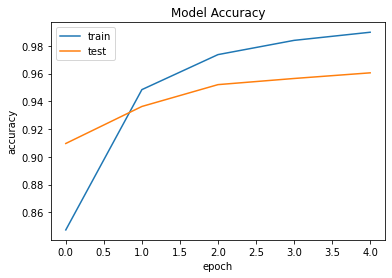

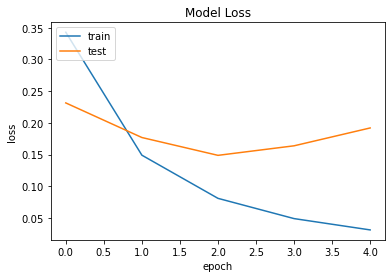

In [48]:
score = model_st_lstm.evaluate(test_sequences, test_labels)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_st_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_st_lstm.history['accuracy'])
plt.plot(history_st_lstm.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_st_lstm.history['loss'])
plt.plot(history_st_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 7. GRU (Gated Recurrent Unit

In [49]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 70, 100)           3000000   
_________________________________________________________________
gru (GRU)                    (None, 70, 32)            12864     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 3,013,409
Trainable params: 3,013,409
Non-trainable params: 0
____________________________________________

In [50]:
history_gru = model_gru.fit(train_sequences, train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_sequences, test_labels), 
                    callbacks=[rlrp] ,verbose=1)

Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 210s 5ms/sample - loss: 0.3397 - accuracy: 0.8491 - val_loss: 0.2250 - val_accuracy: 0.9104
Epoch 2/5
44262/44262 [==============================] - 207s 5ms/sample - loss: 0.1451 - accuracy: 0.9490 - val_loss: 0.1709 - val_accuracy: 0.9372
Epoch 3/5
44262/44262 [==============================] - 209s 5ms/sample - loss: 0.0726 - accuracy: 0.9758 - val_loss: 0.1465 - val_accuracy: 0.9537
Epoch 4/5
44262/44262 [==============================] - 208s 5ms/sample - loss: 0.0388 - accuracy: 0.9881 - val_loss: 0.1425 - val_accuracy: 0.9595
Epoch 5/5
44262/44262 [==============================] - 207s 5ms/sample - loss: 0.0188 - accuracy: 0.9945 - val_loss: 0.1659 - val_accuracy: 0.9631


11066/11066 [==============================] - 7s 642us/sample - loss: 0.1659 - accuracy: 0.9631
Test Loss:  0.16593464672768793
Test Accuracy 0.9631303
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


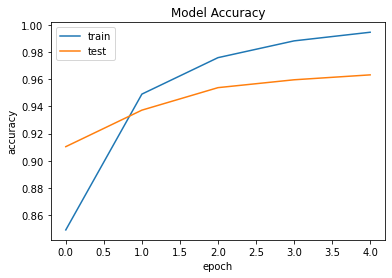

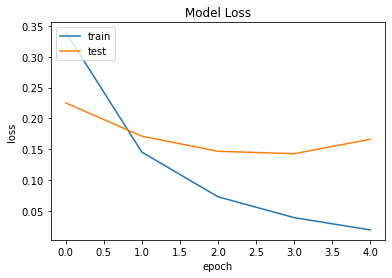

In [51]:
score = model_gru.evaluate(test_sequences, test_labels)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_gru.history.keys())
# summarize history for accuracy
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Bidirectional LSTM

In [52]:
from tensorflow.keras.callbacks import ReduceLROnPlateau 

model_bidir = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_bidir.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidir.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 70, 100)           3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 64)            34048     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 3,035,105
Trainable params: 3,035,105
Non-trainable params: 0
____________________________________________

In [53]:
history_bidir = model_bidir.fit(train_sequences, train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_sequences, test_labels), 
                    callbacks=[rlrp] ,verbose=1)

Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 64s 1ms/sample - loss: 0.3054 - accuracy: 0.8664 - val_loss: 0.1808 - val_accuracy: 0.9314
Epoch 2/5
44262/44262 [==============================] - 54s 1ms/sample - loss: 0.0962 - accuracy: 0.9661 - val_loss: 0.1353 - val_accuracy: 0.9575
Epoch 3/5
44262/44262 [==============================] - 58s 1ms/sample - loss: 0.0320 - accuracy: 0.9896 - val_loss: 0.1337 - val_accuracy: 0.9666
Epoch 4/5
44262/44262 [==============================] - 53s 1ms/sample - loss: 0.0135 - accuracy: 0.9962 - val_loss: 0.1637 - val_accuracy: 0.9635
Epoch 5/5
44262/44262 [==============================] - 53s 1ms/sample - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.1817 - val_accuracy: 0.9672


11066/11066 [==============================] - 2s 194us/sample - loss: 0.1817 - accuracy: 0.9672
Test Loss:  0.18167541902245732
Test Accuracy 0.9671968
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


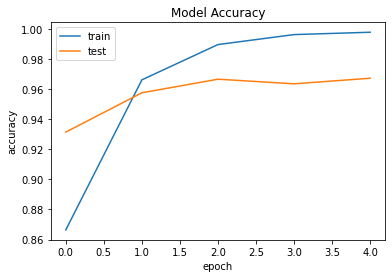

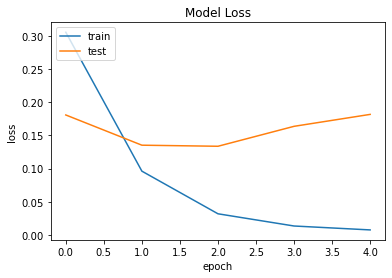

In [54]:
score = model_bidir.evaluate(test_sequences, test_labels)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_bidir.history.keys())
# summarize history for accuracy
plt.plot(history_bidir.history['accuracy'])
plt.plot(history_bidir.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bidir.history['loss'])
plt.plot(history_bidir.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Conclusion

The best models are using LSTM and Bidirectional LSTM along with GlobalMaxPooling and Spatial Dropout. 

Best test Accuracy - 96.71 %
Best test Loss - 0.15


The enhanced data increased the accuracy by almost 11% which is a lot. It goes without saying, that Data is the fuel for the Deep Learning Algorithms.

### License

MIT License

Copyright (c) 2020 Nikhil Kohli

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.